<a href="https://colab.research.google.com/github/rlathwls03/AI-interviewer/blob/main/Step2_%ED%8C%80%EA%B3%BC%EC%A0%9C_AI%EB%A9%B4%EC%A0%91%EA%B4%80_Agent_v2_gradio%ED%8F%AC%ED%95%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step2_AI면접관 Agent v2.0**

## **0. 미션**

### 미션③ : 고도화

* 1) 모듈 고도화 : 다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.
    * 사전 준비 단계 고도화 : Resume 요약, 전략도출 등 단계 고도화 시도
    * 답변에 대한 평가 고도화 : 평가가 적절한지 피드백 : reflection 노드 추가
    * 질문 생성 고도화 : 전략 별 참조 질문 Vector DB 구성
    * 인터뷰 진행 검토 : 기준에 따라 종료 여부 검토, 추가질문(같은 부문 심화 질문?, 새로운 부문 질문?)
    * 최종 평가 피드백 : 질문과 답변에 대한 최종 평가 보고서 제공

* 2) 웹 화면 연결(Gradio)


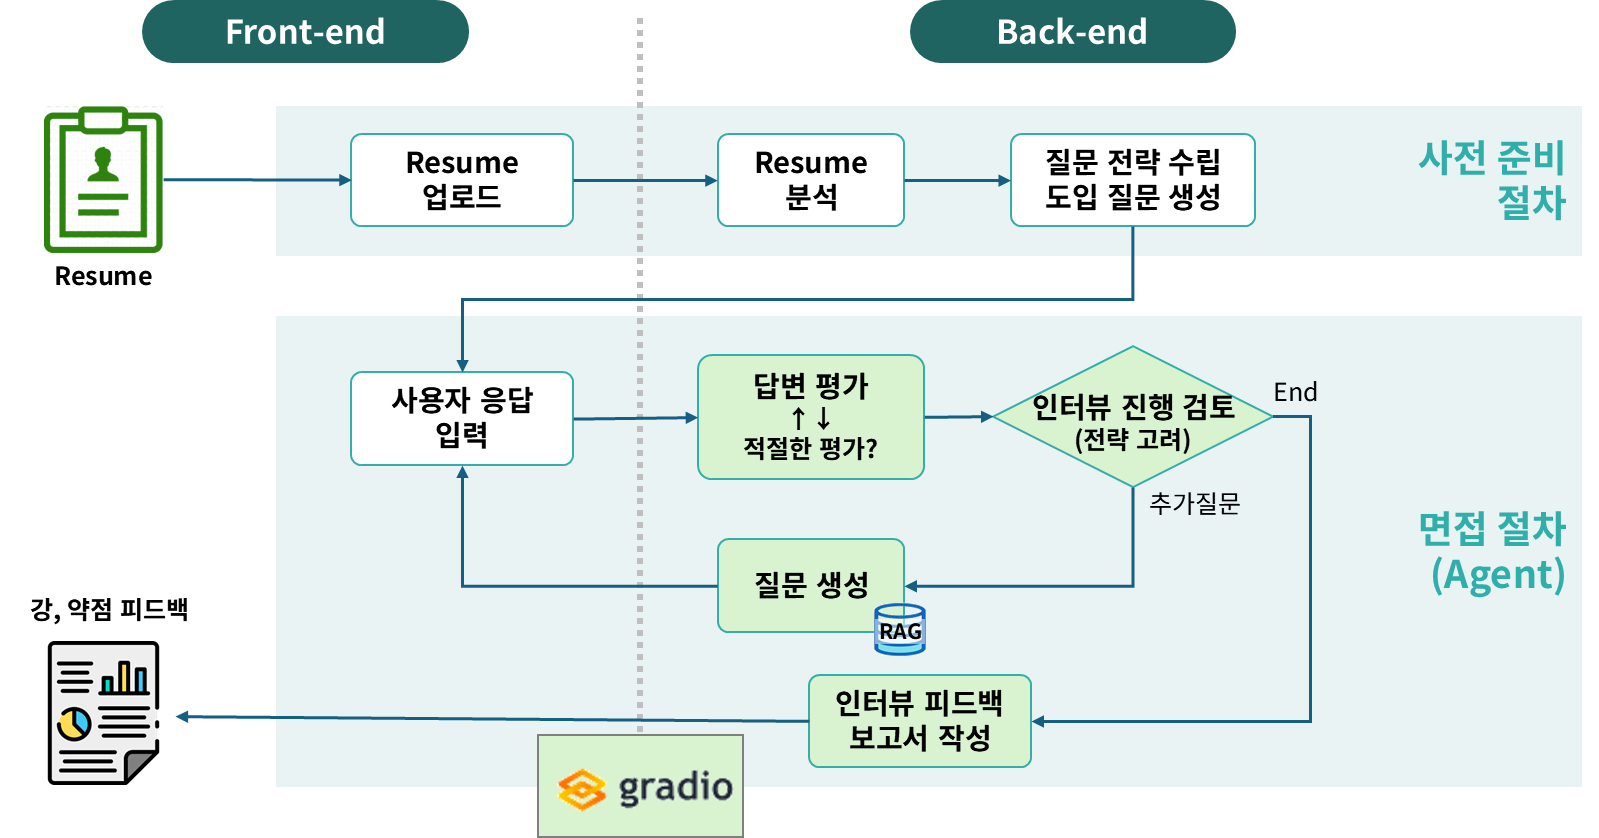

## **1. 환경준비**

### (1) 구글 드라이브

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(project_genai)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 라이브러리

#### 1) 필요한 라이브러리 설치

In [2]:
!pip install langchain_openai langchain_core langchain-community -q
!pip install PyMuPDF
!pip install python-docx
!pip install -U langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.4 which is incompatible.
langchain 0.3.27 requires langchain-text-splitters<1.0.0,>=0.3.9, but you have langchain-text-splitters 1.0.0 which is incompatible.
   ━━━━━━━━

#### 2) 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import os
import ast
import fitz  # PyMuPDF
from docx import Document
import random
import openai
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser, CommaSeparatedListOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langgraph.graph import StateGraph, START, END

import json

In [4]:
from langchain_core.output_parsers import JsonOutputParser

In [5]:
!pip install chromadb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.4 MB/s et

### (3) OpenAI API Key 확인

In [6]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/project_genai/'
# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

## **2. 미션③ : 고도화1**

* 미션① 고도화
    * Step1의 코드들을 붙어 넣고, 고도화가 필요하다면 코드를 개선합니다.
    * 개선 권장 부분
        * Resume 분석 : 요약 및 키워드 범위를 정하는 프롬프트 개선
        * 질문 전략 수립 : 3가지 부문 조정하고 질문 전략을 잘 뽑기 위한 프롬프트 개선

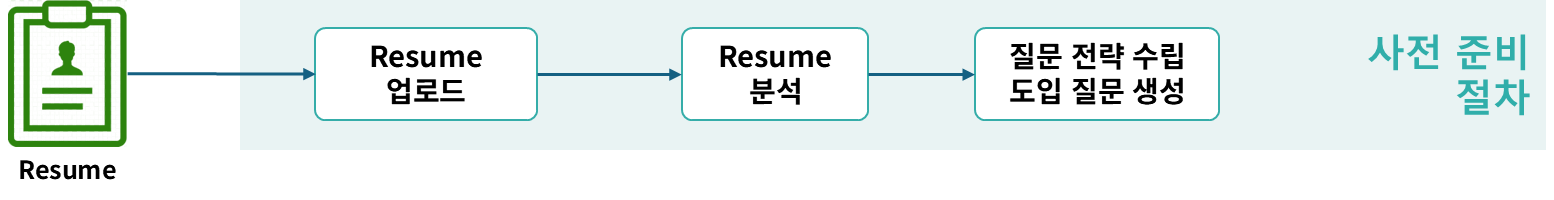

### (1) 파일 입력

In [ ]:
def extract_text_from_file(file_path: str) -> str:
    ext = os.path.splitext(file_path)[1].lower()

    if ext == ".pdf":
        doc = fitz.open(file_path)
        text = "\n".join(page.get_text() for page in doc)
        doc.close()
        return text

    elif ext == ".docx":
        doc = Document(file_path)
        return "\n".join(p.text for p in doc.paragraphs if p.text.strip())

    else:
        raise ValueError("지원하지 않는 파일 형식입니다. PDF 또는 DOCX만 허용됩니다.")

### (2) State 선언

In [ ]:
from typing import TypedDict, List, Dict

#[추가]안세홍_1031_15:23
class EvaluationItem(TypedDict):
    grade: str           # 등급
    description: str     # 설명


class InterviewFeedback(TypedDict):
    relevance: EvaluationItem        # '질문과의 연관성'
    specificity: EvaluationItem    # '답변의 구체성'
    overall_comment: str           # '총평'
# ---------------------------------------------------------------


class InterviewState(TypedDict):
    # 고정 정보
    job_summary: Dict[str,List[str]] #[추가]이진아_1031_14:45

    resume_text: str
    resume_summary: str
    resume_keywords: List[str]
    question_strategy: Dict[str, Dict]
    question_category: Dict[str, int] #[추가]이유환

    # 인터뷰 로그
    current_question: str
    current_answer: str
    current_strategy: str
    conversation: List[Dict[str, str]]
    # evaluation : List[Dict[str, str]]
    evaluation : List[InterviewFeedback] #[수정]안세홍_1031_15:23
    next_step : str

    # 재평가 로직을 위한 필드
    reflection_status: str  # "정상" or "재평가 필요"   #[추가]안세홍_1031_15:23
    retry_count: int        # 0: 첫 시도, 1: 재시도     #[추가]안세홍_1031_15:23

In [ ]:
# 테스트를 위한 초기 상태 구성
initial_state: InterviewState = {
    "job_summary": {}, #[추가]이진아_1031_14:45
    "resume_text": '',
    "resume_summary": '',
    "resume_keywords": [],
    "question_strategy": {},
    'question_category': {},  #[추가]이유환

    "current_question": '',
    "current_answer": '',
    "current_strategy": '',
    "conversation": [],
    "evaluation": [],
    "next_step" : ''
}

In [ ]:
#[추가]이진아_1031_16:00
def job_description_input(state: InterviewState) -> InterviewState:
    """
    사용자가 직접 채용공고를 입력하고 채용공고 분석
    """
    # 1️) 모델 설정
    llm = ChatOpenAI(model_name="gpt-4.1-mini", temperature=0.8)

    print("\n 지원하고자 하는 채용공고를 입력하세요. (입력 완료 후 Enter 두 번)")
    print("-----------------------------------------------------")

    # 2) 입력 데이터 준비(채용 공고 데이터 입력 받기)
    lines = []
    while True:
        line = input()
        if line == "":
            break
        lines.append(line)
    job_text = "\n".join(lines)

    # 3️) 프롬프트 구성
    h_msg = f"""채용공고:{job_text}"""
    s_msg = """
    당신은 채용공고를 분석하는 HR 전문가입니다.
    반드시 다음 JSON 형식에 맞춰 'job_summary'와 'job_keywords'를 생성해 주세요.
    'job_keywords'는 채용공고 지원자에게 요구하는 핵심 역량 키워드입니다.

    출력은 반드시 다음 JSON 형식으로 작성하세요:
    {{
      "job_summary": "채용공고의 핵심내용을 요약한 2-3문장의 요약본입니다.",
      "job_keywords": ["핵심역량1", "핵심역량2", "핵심역량3", ..., "핵심역량10"]
    }}
    """
    # 4️) 프롬프트 구성
    chat_prompt = ChatPromptTemplate.from_messages([
        ("system", s_msg),
        ("human", h_msg)
    ])
    chain = chat_prompt | llm | JsonOutputParser()

    # 5) 모델 호출
    response = chain.invoke({})
    job_summary = response["job_summary"]
    job_keywords = response["job_keywords"]

    # 6️) 결과 저장
    job_info = response

    return {
        **state,
        "job_summary": job_summary,
        "job_keywords" : job_keywords,
    }

### (3) Resume 분석

In [ ]:
def analyze_resume(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.
    resume_text = state["resume_text"]
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

    analysis_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 IT/AI 직무 전문 HR 매니저입니다. 제공된 [이력서 및 자기소개서] 텍스트를 분석하여, '핵심 요약'과 '주요 키워드'를 추출해야 합니다.
        반드시 다음 JSON 형식에 맞춰 'resume_summary'와 'resume_keywords'를 생성해 주세요.
        {{
          "resume_summary": "지원자의 핵심 역량, 주요 경험 및 강점을 요약한 2-3문장의 요약본입니다.",
          "resume_keywords": ["키워드1", "키워드2", "키워드3", ..., "키워드10"]
        }}"""),
        ("human", "[이력서 및 자기소개서]\n{resume_text}")
    ])
    chain = analysis_prompt | llm | JsonOutputParser()
    analysis_result = chain.invoke({"resume_text": resume_text})

    resume_summary = analysis_result["resume_summary"]
    resume_keywords = analysis_result["resume_keywords"]

    # return 코드는 제공합니다.
    return {
        **state,
        "resume_summary": resume_summary,
        "resume_keywords": resume_keywords,
    }


### (4) 질문 전략 수립

In [ ]:
def generate_question_strategy(state: InterviewState) -> InterviewState:
    """이력서 요약과 키워드를 기반으로 3개 영역의 질문 전략을 생성합니다.
       (지원 동기 및 입사 후 포부, 경력 및 경험, 직무 전문성, 문제 해결력)
    """
    # 1️⃣ 모델 설정
    llm = ChatOpenAI(model_name="gpt-4.1-mini", temperature=0.8, top_p=0.9)

    # 2️⃣ 입력 데이터 준비
    j_summary = state["job_summary"] #[추가]_이진아_1031_16:00
    j_keywords = state["job_keywords"] #[추가]이진아_1031_16:00
    summary = state["resume_summary"]
    keywords = ", ".join(state["resume_keywords"])

     # 3️⃣ 프롬프트 구성  #[추가]_이진아_1031_16:00
    h_msg = f"""채용공고 핵심요약:{j_summary} 채용공고 주요 키워드:{j_keywords}이력서 요약:{summary}이력서 주요 키워드:{keywords}"""
    s_msg = """
        아래의 채용공고 핵심요약과 이력서 요약과 주요 키워드를 참고하여,
        채용공고 핵심요약에 적합한 면접 질문 전략을 5가지 영역으로 설계해 주세요:
        1. 지원 동기 및 입사 후 포부
        2. 경력 및 경험
        3. 직무 전문성
        4. 문제 해결력

        각 영역에 대해 아래 정보를 포함해 주세요:
        - 질문 방향: 어떤 점을 중점적으로 평가할지 설명
        - 예시 질문: 해당 영역에서 사용할 수 있는 질문 2개

        출력은 반드시 다음 JSON 형식으로 작성하세요:
        {{
          "지원 동기 및 입사 후 포부": {{
              "질문 방향": "지원자의 기업 지원동기와 직무 이해도를 파악하기 위한 방향 설명",
              "예시 질문": ["예시1", "예시2"]
            }},
          "경력 및 경험" :{{
              "질문 방향": "경험과 경력 검증과 경험과 경력을 통해 함양했던 역량을 파악하기 위한 방향 설명",
              "예시 질문": ["예시1", "예시2"]
            }},
          "직무 전문성": {{
              "질문 방향": "채용공고에서 요구하는 직무전문성을 지원자가 보유하고 있는지를 파악하기 위한 방향 설명",
              "예시 질문": ["예시1", "예시2"]
            }},
          "문제 해결력": {{
              "질문 방향": "문제해결력을 보유하고 있는지 파악하기 위한 방향 설명",
              "예시 질문": ["예시1", "예시2"]
        }}"""

    # 4️⃣ 프롬프트 구성
    chat_prompt = ChatPromptTemplate.from_messages([
        ("system", s_msg),
        ("human", h_msg)
    ])
    chain = chat_prompt | llm | JsonOutputParser()

    # 5️⃣ 모델 호출
    response = chain.invoke({
        "resume_summary": summary,
        "resume_keywords": keywords
    })
    # 6️⃣ 결과 저장
    strategy_dict = response
    temp =  {key: 0 for key in strategy_dict.keys()}#수정됨

    # return 코드는 제공합니다.
    return {
        **state,
        "question_strategy": strategy_dict
    }


### (5) 하나로 묶기

In [ ]:
def preProcessing_Interview(file_path: str) -> InterviewState:
    """이력서 파일 입력부터 질문 전략 수립, 첫 질문 생성까지 한 번에 실행."""

   # 1️⃣ 파일 입력
    resume_text = extract_text_from_file(file_path)

    # 2️⃣ state 초기화
    state: InterviewState = {
        "job_summary": '', #[추가]이진아_1031_16:00
        "job_keywords" : [], #[추가]이진아_1031_16:00
        "resume_text": resume_text,
        "resume_summary": "",
        "resume_keywords": [],
        "question_strategy": {},
        "question_category": {},  #[추가]이유환
        "current_question": "",
        "current_answer": "",
        "current_strategy": "",
        "conversation": [],
        "evaluation": [],
        "next_step": ""
    }
    # 3️⃣ 채용공고 분석 #[추가]이진아_1031_16:00
    state = job_description_input(state)

    # 4️⃣ Resume 분석
    state = analyze_resume(state)

    # 5) 질문 전략 수립 #[추가]이진아_1031_16:00
    state = generate_question_strategy(state)

    selected_question = state["question_strategy"]["지원 동기 및 입사 후 포부"]["예시 질문"][0]


    # return 코드는 제공합니다.#[추가]이진아_1031_16:00
    return {
            **state,
            "current_question": selected_question,
            "current_strategy": "지원 동기 및 입사 후 포부"
            }

## **3. 미션③ : 고도화2**

* 미션② 고도화
    * 답변에 대한 평가 고도화
        * 평가가 적절한지 피드백 : reflection 노드 추가
    * 질문 생성 고도화
        * 생성된 질문이 적절한지 피드백 : reflection 노드 추가
        * 전략 별 참조 질문 Vector DB 구성
    * 최종 평가 피드백
        * 질문과 답변에 대한 최종 평가 보고서 제공


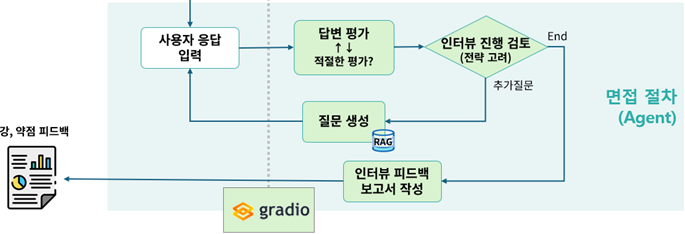

### (1) 답변 입력

In [ ]:
def update_current_answer(state: InterviewState, user_answer: str) -> InterviewState:

    return {
        **state,
        "current_answer": user_answer.strip()
    }


### (2) 답변 평가 : 고도화
* 고도화 제안
    * 평가가 적절한지 피드백 : reflection 노드 추가
    * conversation 저장이 중복되지 않도록 코드 조정

| 항목 | 설명 |
| ---- | ---- |
 목적 | 최근 평가가 적절한지 되돌아보고 판단 (보완 필요 여부 포함)
 입력 | current_question, current_answer, evaluation[-1]
 출력 | 판단 결과: "정상" or "재평가 필요" → state["reflection_status"] 저장
분기 구조 | "정상" → decide_next_step, "재평가 필요" → re_evaluate_answer



In [ ]:
def evaluate_answer(state: InterviewState) -> InterviewState:
    """지원자의 답변을 평가하여 등급 생성 """
    llm = ChatOpenAI(model_name="gpt-4.1-mini", temperature=0)

    s_msg = """당신은 HR 인터뷰 평가 전문가입니다.
    지원자의 답변을 다음 두 항목으로 평가하세요:
    1. 질문과의 연관성(relevance)
    2. 답변의 구체성(specificity)

    [평가 기준]
    - 질문과의 연관성
      • 상(우수): 질문의 핵심 의도에 정확히 부합
      • 중(보통): 관련은 있으나 핵심 포인트 일부 누락
      • 하(미흡): 질문과 관련이 약함
    - 답변의 구체성
      • 상(우수): 실제 사례, 수치 등 구체적 근거 제시
      • 중(보통): 일반적이지만 일부 구체적 내용 포함
      • 하(미흡): 모호하거나 추상적인 표현 중심

    - overall_comment(총평)은 두 항목을 종합한 전반적인 평가를 서술하세요.

    출력은 반드시 아래 JSON 형식으로 작성하세요:
    {{
      "relevance": {{"grade": "상", "description": "..."}},
      "specificity": {{"grade": "중", "description": "..."}},
      "overall_comment": "전반적으로 답변이 구체적이며 질문과의 연관성이 높음"
    }}
    """
    h_msg = """[question]
    {question}
    [answer]
    {answer}
    """
    chat_prompt = ChatPromptTemplate.from_messages([
        ("system", s_msg),
        ("human", h_msg)
    ])
    chain = chat_prompt | llm | JsonOutputParser()
    current_qa = {
        "question": state["current_question"],
        "answer": state["current_answer"]
        }
    # 새 평가 생성
    new_evaluation = chain.invoke(current_qa)

    # # 기존 평가 리스트에 새 평가 추가
    evaluation = state["evaluation"] + [new_evaluation]

    return {
        **state,
        "evaluation": evaluation
    }

In [ ]:
# 평가 검토 노드

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import json
def reflection_node(state: InterviewState) -> Dict:
    # 1. 현재 재시도 횟수 확인
    current_retry_count = state.get("retry_count", 0)

    if current_retry_count > 0:
        return {
            "reflection_status": "정상", # 루프를 빠져나가기 위해 '정상'으로 설정
            "retry_count": 0            # 다음 Q/A를 위해 카운트 리셋
        }

    last_evaluation = state["evaluation"][-1]

    # 3. 1차 평가 검증 LLM 실행 (기존 로직 동일)
    check_prompt = ChatPromptTemplate.from_messages([
        ("system",  """(검증 프롬프트... "정상" or "재평가 필요" 출력)"""),
        ("human", """[질문]
          {question}
          [답변]
          {answer}
          """ )])

    llm_check = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
    check_chain = check_prompt | llm_check | StrOutputParser()
    reflection_status = check_chain.invoke({
        "question": state["current_question"],
        "answer": state["current_answer"]
    })
    # 4. 검증 결과 처리
    updated_evaluations = state["evaluation"]
    next_retry_count = 0

    if reflection_status == "재평가 필요":

        updated_evaluations = state["evaluation"][:-1] # 잘못된 평가 제거
        next_retry_count = 1                          # 재시도 카운트 1로 설정
    else:
        pass

    return {
        "reflection_status": reflection_status,
        "evaluation": updated_evaluations, # (재평가 필요 시) 수정된 리스트
        "retry_count": next_retry_count    # (재평가 필요 시) 1
    }

In [ ]:
def save_conversation(state: InterviewState) -> Dict:

    new_conversation_turn = {
        "question": state["current_question"],
        "answer": state["current_answer"]
    }

    updated_conversation = state.get("conversation", []) + [new_conversation_turn]

    return {
        "conversation": updated_conversation
    }

### (3) 인터뷰 진행 검토 : 고도화

* 조건
    * 모든 전략 영역을 한 번 이상 커버했으면 → "end"
    * 전체 질문&답변이 5번 진행되었으면 → "end"  (인터뷰가 너무 길어지는 것 방지)
    * 가장 최근 평가에 "하"가 있다면 → additional_question (현재 전략 유지)
    * 최근 평가가 "상" or "중" → next_strategy (다음 전략으로 전환)

In [ ]:
def decide_next_step(state: InterviewState) -> InterviewState:
    add_followup = False
    next_step = ""

    conversation_count = len(state.get("conversation", []))
    question_category = state.get("question_category", {})
    current_strategy = state.get("current_strategy", "")
    evaluation_list = state.get("evaluation", [])
    recent_eval = evaluation_list[-1] if evaluation_list else {}

     # ✅ 1️⃣ 첫 번째 질문일 때 초기화 로직 추가
    if conversation_count == 1:
        # 기본 카테고리 초기화 (면접 시작 시점)
        if not question_category:
            question_category = {"지원 동기 및 입사 후 포부": 1}
            current_strategy = "지원 동기 및 입사 후 포부"

    # 인터뷰 종료 조건
    if conversation_count >= 8:
        next_step = "end"

    else:
        # 현재 카테고리 질문 횟수 조회 (없으면 0)
        count = question_category.get(current_strategy, 0)
        checkList = [recent_eval["relevance"]["grade"], recent_eval["specificity"]["grade"]]

        # 2회 미만이면 꼬리질문 여부 판단
        if count < 2:
            if all(val == "상" for val in checkList):
                add_followup = False
            else:
                add_followup = True


        else:
            add_followup = False

        # 다음 단계 결정
        if add_followup:
            next_step = "additional_question"
        else:
            next_step = "next_question"

    return {
        **state,
        "next_step": next_step,
        "question_category": question_category
    }


### (4) 질문 생성 : 고도화

* 요건
    * 현재 generate_question()은 기존 전략 예시 질문과 최근 답변을 기반으로 심화 질문 생성
    * 여기에 Chroma Vector DB를 추가해서, 유사 질문 3개 정도를 LLM 프롬프트에 참조 정보로 포함
    * 질문은 여전히 LLM이 생성, 유사 질문은 참고로만 사용

In [ ]:
# [추가]배현우_1031_15:54
import json
from langchain.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

def generate_question_dataset(resume_text: str):
    """LLM을 통해 질문 데이터셋을 생성하고 Vector DB에 저장합니다."""

    # 1️⃣ LLM 설정
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.8)

    # 2️⃣ 프롬프트 정의
    system_prompt = f"""
    당신은 HR 인터뷰 전문가이자 채용 면접 질문 생성 전문가입니다.
    아래 지원자의 이력서 내용을 분석하여 아래 네 가지 카테고리에 대해 실제 면접에서 사용할 수 있는 질문을 생성하세요.
    각 질문은 JSON 객체 형태로 'question'과 'category' 키를 반드시 포함해야 합니다.

    [지원자 이력서 내용]
    {resume_text}

    [카테고리 목록]
    1. 지원 동기 및 입사 후 포부
    2. 경력 및 경험
    3. 직무 전문성
    4. 문제 해결력

    [질문 생성 규칙]
    - 각 영역당 5개
    - 한 문장으로 명확하게 작성
    - 예/아니오로 답할 수 없게 구성
    - JSON 형식 예시:
    [
      {{"question": "왜 우리 회사에 지원했나요?", "category": "지원 동기 및 입사 후 포부"}},
      {{"question": "최근 맡았던 프로젝트에서 가장 어려웠던 점은?", "category": "경력 및 경험"}}
    ]
    """

    # 3️⃣ LLM 호출
    response = llm.invoke([("system", system_prompt)])
    content = response.content.strip()

    # 4️⃣ 코드블록(````json ... `````) 제거
    if content.startswith("```"):
        content = content.strip("`")
        if content.startswith("json"):
            content = content[4:].strip()

    # 5️⃣ JSON 파싱
    try:
        question_list = json.loads(content)
    except json.JSONDecodeError as e:
        print("⚠️ LLM 응답이 JSON 형식이 아닙니다.")
        print("원본 출력:\n", content)
        print("\n에러 메시지:", e)
        return

    # 6️⃣ 임베딩 및 Vector DB 초기화
    embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = Chroma(
        collection_name="interview_questions",
        embedding_function=embedding_model,
        persist_directory="./chroma_db"
    )

    # 7️⃣ Vector DB에 저장
    for q in question_list:
            question_text = q.get("question", "").strip()
            category = q.get("category", "").strip()

            if not question_text or not category:
                continue

            embedding = embedding_model.embed_query(question_text)

            vectorstore.add_texts(
                texts=[question_text],
                metadatas=[{
                    "category": category
                }],
                embeddings=[embedding]
            )


    vectorstore.persist()
    return vectorstore

In [ ]:
def generate_question(state: InterviewState) -> InterviewState:
    """면접 진행 상태(state)에 따라 다음 질문을 자동 생성한다.
       next_step에 따라 꼬리질문 또는 새로운 질문을 생성한다.
    """

    # 1️⃣ state에서 기본 정보 추출
    job_summary = state.get("job_summary", "")
    job_keywords = state.get("job_keywords", [])
    resume_text = state.get("resume_text", "")
    resume_summary = state.get("resume_summary", "")
    resume_keywords = state.get("resume_keywords", [])
    question_strategy = state.get("question_strategy", {})
    question_category = state.get("question_category", {})
    prev_question = state.get("current_question", "")
    prev_answer = state.get("current_answer", "")
    next_step = state.get("next_step", "")
    conversation = state.get("conversation", [])
    n = len(state.get("conversation", []))
    current_category = state.get("current_strategy", "")

    # 🔹 n 값 기준으로 current_category 자동 설정 (백업용)
    if n == 1:
        current_category = "지원 동기 및 입사 후 포부"
    elif n in [2, 3]:
       current_category = "경력 및 경험"
    elif n in [4, 5]:
        current_category = "직무 전문성"
    elif n in [6, 7]:
       current_category = "문제 해결력"

    # 🔸 최근 평가 결과
    evaluation_item = state["evaluation"][n - 1] if n > 0 else {}
    evaluation_text = "\n".join([f"{k}: {v}" for k, v in evaluation_item.items()])
    evaluation = evaluation_text

    # 2️⃣ 벡터스토어 및 임베딩 모델
    vectorstore = generate_question_dataset(resume_text)
    embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

    # 3️⃣ 카테고리 기반 질문 검색
    query_context = f"[현재 카테고리]\n{current_category}"
    query_embedding = embedding_model.embed_query(query_context)
    similar_docs = vectorstore.similarity_search_by_vector(
        query_embedding,
        k=3,
        filter={"category": current_category} if current_category else None
    )
    reference_questions = "\n".join([doc.page_content for doc in similar_docs]) if similar_docs else "없음"

    # 4️⃣ LLM 모델 준비
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

    # 5️⃣ next_step에 따라 프롬프트 분기
    if next_step == "additional_question":
        # 🔹 꼬리질문 모드
        prompt = ChatPromptTemplate.from_messages([
            ("system", f"""당신은 HR 인터뷰 전문가입니다.
            지원자의 이전 질문과 답변을 기반으로, 같은 주제 내에서 깊이 있는 꼬리질문을 생성하세요.

            [출력 형식]
            - {current_category} 영역의 단 하나의 질문 문장만 출력합니다.
            - 'Q:' 같은 접두사는 포함하지 않습니다.
            """),
            ("human", """
            [현재 카테고리]
            {current_category}

            [이전 질문]
            {prev_question}

            [이전 답변]
            {prev_answer}

            [평가 결과]
            {evaluation}

            [참고 질문 예시]
            {reference_questions}

            위 정보를 바탕으로, 같은 주제에서 지원자의 사고력과 구체성을 더 파악할 수 있는 꼬리질문을 하나 생성하세요.
            """)
        ])

        prompt_vars = dict(
            current_category=current_category,
            prev_question=prev_question,
            prev_answer=prev_answer,
            evaluation=evaluation,
            reference_questions=reference_questions
        )

    else:
        # 🔹 새로운 질문 모드
        prompt = ChatPromptTemplate.from_messages([
            ("system", f"""당신은 HR 인터뷰 전문가이자 기술 면접관입니다.
            주어진 카테고리 내에서 지원자의 역량과 사고력을 평가할 수 있는 새로운 질문을 생성하세요.

            [출력 형식]
            - {current_category} 영역의 단 하나의 질문 문장만 출력합니다. 주어진 내용과 이전 대화를 참고하여 질문
            내용이 겹치지 않게 새로운 질문을 출력하세요.
            - 'Q:' 같은 접두사는 포함하지 않습니다.
            """),
            ("human", """
            [현재 카테고리]
            {current_category}

            [채용 공고 요약]
            {job_summary}

            [채용 공고 키워드]
            {job_keywords}

            [이전 대화 내용]
            {conversation}

            [이력서 요약]
            {resume_summary}

            [주요 키워드]
            {resume_keywords}

            [참고 질문 예시]
            {reference_questions}

            위 정보를 참고해, 지원자의 {current_category} 영역을 평가할 수 있는 새로운 질문을 하나 생성하세요.
            """)
        ])

        prompt_vars = dict(
            current_category=current_category,
            job_summary=job_summary,
            job_keywords=job_keywords,
            conversation=conversation,
            resume_summary=resume_summary,
            resume_keywords=resume_keywords,
            reference_questions=reference_questions
        )

    # 6️⃣ LLM 호출
    response = llm.invoke(prompt.format_messages(**prompt_vars))
    new_question = response.content.strip()

    # 7️⃣ 카테고리 카운트 갱신
    question_category[current_category] = question_category.get(current_category, 0) + 1

    # 🔚 최종 반환
    return {
        **state,
        "current_question": new_question,
        "current_answer": "",
        "current_strategy": current_category,
        "question_category": question_category
    }

### (5) 인터뷰 피드백 보고서 : 고도화


* 제안
    * 전략별 요약 : 각 전략 영역별로 답변 스타일, 강점/약점 정리
    * 종합 피드백 : 전체 인터뷰의 인상, 강점, 보완점
    * 형식 : 구조화된 텍스트 (분야별 블록 + 전체 종합 평가)
* 입력으로 활용할 요소
    * state["conversation"]       # 질문/답변 리스트
    * state["evaluation"]         # 질문별 평가 (연관성, 구체성)
    * state["question_strategy"]  # 전략 분류용

In [ ]:
def summarize_interview(state: InterviewState) -> InterviewState:
    """면접 종료 시, 카테고리별 질문/답변/평가 내용을 구분하여 요약 출력"""

    import re

    #[추가]이진아_1031_16:00_채용정보 추가
    job_summary = state.get('job_summary', '')
    job_keywords = state.get('job_keywords', [])
    conversation = state.get("conversation", [])
    evaluations = state.get("evaluation", [])
    resume_text = state.get('resume_text', '')
    resume_summary = state.get('resume_summary', '')
    resume_keywords = state.get('resume_keywords', [])
    question_strategy = state.get('question_strategy', [])

    print("=== 인터뷰 종료 리포트 ===")

    # 🔹 카테고리별로 대화 그룹핑
    grouped_data = {
        "지원 동기 및 입사 후 포부": {"qa": [], "eval": []},
        "경력 및 경험": {"qa": [], "eval": []},
        "직무 전문성": {"qa": [], "eval": []},
        "문제 해결력": {"qa": [], "eval": []}
    }

    for i, qa in enumerate(conversation):
        if i < 2:
            cat = "지원 동기 및 입사 후 포부"
        elif i < 4:
            cat = "경력 및 경험"
        elif i < 6:
            cat = "직무 전문성"
        else:
            cat = "문제 해결력"

        grouped_data[cat]["qa"].append(qa)
        if i < len(evaluations):
            grouped_data[cat]["eval"].append(evaluations[i])

    # 🔹 LLM 준비
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

    # 🔹 전체 프롬프트
    prompt = ChatPromptTemplate.from_template('''
    다음은 지원자의 면접 정보입니다. 각 카테고리별로 주어진 Q&A와 평가 데이터를 기반으로
    질문 전략별로 요약, 품질 분석, 강점/약점, 종합 평가를 작성하세요.
    절대 다른 카테고리의 내용을 섞지 마세요.

    [채용공고 요약]
    {job_summary}

    [채용공고 핵심역량 키워드]
    {job_keywords}

    [지원자 이력서]
    {resume_text}

    [이력서 요약]
    {resume_summary}

    [키워드]
    {resume_keywords}

    아래는 카테고리별 면접 대화 기록입니다.
    각 카테고리 내 Q&A와 평가만 활용해 해당 카테고리를 평가하세요.

    ==============================
    [카테고리별 면접 기록]
    {grouped_summary}
    ==============================

    분석 지침:
    1) 각 카테고리별로 [질문 전략] 섹션을 구분해 출력합니다.
    2) 다른 카테고리의 내용이나 없는 정보를 절대 추가하지 마세요.
    3) 카테고리 순서: 지원 동기 및 포부 → 경력 및 경험 → 직무 전문성 → 문제 해결력
    4) 각 섹션마다 질문/답변 요약, 품질 분석, 강점, 약점, 종합 평가를 작성하세요.
    5) 출력 형식은 아래를 그대로 따르세요. Markdown 금지.
    6) 각 질문 전략별로, 실제 면접 대화에 해당 전략의 질문이 존재하지 않는 경우에는 해당 전략의 전체
    섹션을 작성하지 마세요. 즉, 면접 대화에서 질문이 없거나 평가 데이터가 없는 전략은 생략합니다.
    생략된 전략은 허구로 작성하지 않습니다.

    [질문 전략] 지원 동기 및 포부
        [1] 질문/답변 요약
        - 내용
        [2] 답변 품질 분석
        - 내용
        [3] 강점 분석
        - 내용
        - 내용
        - 내용
        [4] 약점 분석
        - 내용
        - 내용
        - 내용
        [5] 종합 평가
        - 내용

    [질문 전략] 경력 및 경험
        (동일한 형식 반복)

    [질문 전략] 직무 전문성
        (동일한 형식 반복)

    [질문 전략] 문제 해결력
        (동일한 형식 반복)

    마지막에 아래 문단 작성:
    최종 요약 평가 (3줄)
    - 줄1
    - 줄2
    - 줄3
    ''')

    # 🔹 카테고리별 Q&A 텍스트 정리
    grouped_summary = ""
    for category, data in grouped_data.items():
        qa_text = "\n".join([f"Q: {x['question']}\nA: {x['answer']}" for x in data["qa"]])
        eval_text = "\n".join([f"{k}: {v}" for ev in data["eval"] for k, v in ev.items()])
        grouped_summary += f"\n[{category}]\n{qa_text}\n\n평가 요약:\n{eval_text}\n"

    chain = prompt | llm
    response = chain.invoke({
        'job_summary':job_summary,
        'job_keywords':job_keywords,
        "resume_text": resume_text,
        "resume_summary": resume_summary,
        "resume_keywords": resume_keywords,
        "grouped_summary": grouped_summary
    })

    result = response.content.strip()
    clean_output = re.sub(r"\*\*(.*?)\*\*", r"\1", result)
    clean_output = re.sub(r"#+ ", "", clean_output)

    print("\n" + clean_output)
    return state


### (6) 면접 Agent

In [ ]:
# 분기 판단 함수
def route_next(state: InterviewState) -> Literal["generate", "summarize"]:
    """인터뷰 진행 여부를 결정 (추가 질문 or 종료)"""
    if state.get("next_step") == "end":
        return "summarize"
    else:
        return "generate"

def decide_after_reflection(state: InterviewState) -> Literal["evaluate", "save_conversation"]:
    """
    reflection_status 값에 따라 다음 노드를 결정합니다.
    """
    if state.get("reflection_status") == "재평가 필요":
        return "evaluate" # evaluate 노드로 다시 라우팅
    else:
        return "save_conversation" # save_conversation 노드로 라우팅


# 그래프 정의 시작
builder = StateGraph(InterviewState)

# 노드 추가
    # (1) 답변 입력
builder.add_node("evaluate", evaluate_answer)                # (2) 답변 평가
builder.add_node("reflect", reflection_node)                 # 평가를 평가
builder.add_node("save_conversation", save_conversation)     # 대화 저장
builder.add_node("decide", decide_next_step)                 # (3) 인터뷰 진행 검토
builder.add_node("generate", generate_question)              # (4) 추가 질문 생성
builder.add_node("summarize", summarize_interview)           # (5) 인터뷰 요약 보고서


# 노드 연결
builder.add_edge(START, "evaluate")
builder.add_edge("evaluate", "reflect")
builder.add_conditional_edges(
    "reflect",
    decide_after_reflection,
    {
        "evaluate": "evaluate",
        "save_conversation": "save_conversation"
    }
    )
builder.add_edge("save_conversation", "decide")
builder.add_conditional_edges(
    "decide",
    route_next,
    {
        "generate": "generate",
        "summarize": "summarize"
    }
    )
builder.add_edge("generate", END )  # 추가 질문 후 다시 답변 입력
builder.add_edge("summarize", END)

# 컴파일
graph = builder.compile()

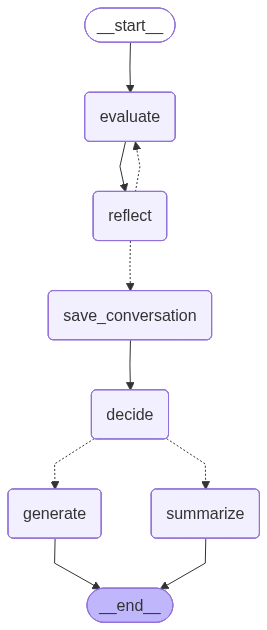

In [ ]:
graph

## **4. 시스템 실행**

미션3에서 수행한 결과를 통합 테스트 해 봅시다.

### (1) 인터뷰 사전준비 작업

In [ ]:

# 파일 입력
file_path = path + 'Resume_sample.pdf'
state = preProcessing_Interview(file_path)
state


 지원하고자 하는 채용공고를 입력하세요. (입력 완료 후 Enter 두 번)
-----------------------------------------------------
[KK기술] 금융 서비스 백엔드 개발자 (신입/주니어) 모집기간: 상시채용 고용형태: 정규직 근무지: 서울 영등포구 (여의도 키움증권 본사 인근) 모집인원: 0명 모집 분야 : 백엔드(서버) 개발자 주요 업무 금융 서비스(증권, 계좌, 인증, 거래) 백엔드 시스템 개발 및 운영 Java(Spring) 기반 API 및 서버 모듈 설계·구현 내부/외부 시스템 연동을 위한 RESTful API 개발 서비스 배포(Jenkins, Docker 등) 및 서버 운영 신규 기능 개발 및 성능 개선, 장애 대응  자격 요건 Java / Spring Framework 기반 웹 서비스 개발 경험 RDBMS(MySQL, Oracle 등) 에 대한 기본 이해 Git, Linux 환경에서의 협업 및 배포 경험 전산, 소프트웨어, 전기정보, 산업공학 등 관련 전공자 문제 해결 중심의 사고와 코드 품질에 대한 관심 새로운 기술을 배우고 적용하는 데 즐거움을 느끼는 사람  우대 사항 Spring Boot, JPA(Hibernate) 사용 경험 클라우드 환경(AWS, GCP, Naver Cloud 등) 이해 Jenkins, Docker 등 CI/CD 환경 구축 경험 금융, 증권, 결제 시스템 프로젝트 경험 알고리즘 문제 해결 및 코드 리뷰 경험 Open Source, GitHub, 개인 블로그 운영 경험  채용 절차  1️⃣ 서류 전형 2️⃣ 온라인 코딩테스트 또는 과제 전형 3️⃣ 기술면접 (개발 실무진) 4️⃣ 임원면접 (조직 적합도 및 커뮤니케이션 평가) 5️⃣ 최종 합격 및 처우 협의   복리후생 유연근무제 / 원격근무 일부 허용 교육비, 도서비, 세미나 참가비 지원 최신 장비 제공 (트리플 모니터, 고성능 개발 장비) 점심 및 간식 지원, 사내 카페 운영 자율복장, 수평적 조직문화 건강검진, 복지포인트, 각종 

                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.


{'job_summary': 'KK기술에서 금융 서비스 분야의 백엔드 개발자를 신입 및 주니어급으로 상시 채용합니다. Java(Spring) 기반의 API 및 서버 모듈 설계, 금융 시스템 연동, 서비스 배포 및 운영 업무를 수행하며, 문제 해결 능력과 코드 품질에 중점을 둔 인재를 찾고 있습니다.',
 'job_keywords': ['Java',
  'Spring Framework',
  'RESTful API',
  'RDBMS',
  'Git',
  'Linux',
  'Jenkins',
  'Docker',
  '문제 해결 능력',
  '금융 서비스 이해'],
 'resume_text': '<이력서> \n홍길동 (Gil-dong Hong) \n이메일: gildong.hong@example.com \n전화번호: 010-1234-5678 \n학력 \n- 한국대학교 전기정보공학부 학사 (2018.03 ~ 2022.02) \n  GPA: 3.91 / 4.3, 전공과목: 머신러닝, 데이터마이닝, 신호처리 \n경력 \n- KT, AI 연구소 인턴 (2021.07 ~ 2021.12) \n  • OCR 기반 문서 처리 시스템 고도화 \n  • Tesseract + 딥러닝 후처리 파이프라인 설계 \n  • 사내 법률문서 정제 정확도 12% 개선 \n- 빅데이터 학생연합 (BDSA) 기술부장 (2020.03 ~ 2021.02) \n  • Python 기반 크롤러 및 Flask API 개발 \n  • 공공데이터 기반 부동산 가격 예측 프로젝트 리드 \n프로젝트 \n- AI 면접관 시스템 개발 (졸업 과제) \n  • OpenAI GPT + Streamlit + FAISS 기반 질문-응답 시스템 구현 \n  • 이력서 기반 질문 자동 생성 + 답변 피드백 제공 \n- 딥러닝 기반 교통량 예측 (교과목 프로젝트) \n  • LSTM 기반 모델 + 서울시 교통데이터 \n  • MAE 15% 이하로 개선 \n기술 스택 \n- Python, PyTorch, TensorFlow, O

### (2) Agent 실행

In [ ]:
# # 사용자 응답 루프
# while True:
#     print("\n[질문]")
#     print(state["current_question"])

#     state["current_answer"] = input("\n[답변 입력]:\n")

#     # 그래프 실행: 평가 → 판단 → 다음 질문 생성 or 종료
#     state = graph.invoke(state)

#     if state["next_step"] == "end":
#         break


[질문]
KK기술의 금융 서비스 백엔드 개발자 직무에 지원한 동기는 무엇인가요?

[답변 입력]:
금융 시스템의 안정성과 정확성이 중요한 환경에서 백엔드 기술 역량을 발휘하고 싶어 지원했습니다. KK기술의 대규모 금융 플랫폼 구조와 기술력에 매력을 느꼈습니다. 안정적이고 신뢰할 수 있는 금융 서비스를 만드는 데 기여하고 싶습니다.

[질문]
입사 후 KK기술의 대규모 금융 플랫폼에서 어떤 특정 기술이나 프로젝트를 통해 본인의 역량을 어떻게 발전시킬 계획이신가요?

[답변 입력]:
대규모 트랜잭션을 처리하는 KK기술의 금융 플랫폼에서 **마이크로서비스 아키텍처(MSA)**와 **비동기 메시징 시스템(Kafka 등)**을 활용한 백엔드 성능 최적화 역량을 키우고 싶습니다. 또한 Spring Cloud 기반의 분산 시스템 관리 및 장애 대응 자동화 프로젝트에 참여해 안정성과 확장성을 높이는 경험을 쌓을 계획입니다. 이를 통해 대규모 금융 데이터 처리와 시스템 신뢰성을 동시에 강화하는 전문 백엔드 개발자로 성장하고자 합니다.

[질문]
KT AI 연구소에서의 인턴 경험을 통해 직면했던 가장 큰 기술적 도전은 무엇이었으며, 그 문제를 어떻게 해결했는지 구체적으로 설명해 주세요.

[답변 입력]:
KT AI 연구소 인턴 당시, 대용량 음성 데이터의 전처리 속도 저하가 가장 큰 기술적 도전이었습니다. 데이터 처리 파이프라인이 순차적으로 동작해 병목이 발생했기에, 멀티프로세싱과 비동기 I/O 구조로 재설계해 병렬 처리 효율을 극대화했습니다. 그 결과 처리 속도를 약 3배 향상시켰고, 모델 학습 주기를 단축해 연구 효율을 크게 높일 수 있었습니다.

[질문]
이전 인턴 경험에서 활용한 머신러닝 및 데이터마이닝 기술이 KK기술의 금융 백엔드 시스템 개발에 어떻게 적용될 수 있다고 생각하시나요?

[답변 입력]:
인턴 시절 활용한 머신러닝 기반 이상 탐지와 데이터마이닝 기법은 금융 거래 데이터에서 비정상 패턴 탐지 및 사기 거래 예방에 적용될 수 있습니다. 또한 대규모 로그 분

In [ ]:
import gradio as gr
import io, contextlib

# 세션 상태 초기화 함수
def initialize_state():
    return {
        "state": None,
        "interview_started": False,
        "interview_ended": False,
        "chat_history": []
    }

def upload_and_initialize(file_obj, job_text, session_state):
    if file_obj is None:
        session_state["chat_history"].append(["", "파일을 업로드해주세요."])
        return session_state, session_state["chat_history"]

    file_path = file_obj.name

    import builtins
    _orig_input = builtins.input
    if job_text and job_text.strip():
        lines = job_text.splitlines()
        it = iter(lines + [""])
        builtins.input = lambda *a, **k: next(it)
    else:
        builtins.input = lambda *a, **k: ""
    try:
        state = preProcessing_Interview(file_path)
    except Exception as e:
        session_state["chat_history"].append(["", f"초기화 중 오류: {e}"])
        return session_state, session_state["chat_history"]
    finally:
        builtins.input = _orig_input

    session_state["state"] = state
    session_state["interview_started"] = True

    first_question = state.get("current_question", "첫 질문 생성에 실패했습니다. 다시 시도하세요.")
    session_state["chat_history"].append(["", first_question])

    return session_state, session_state["chat_history"]

# 답변 처리 및 다음 질문 생성
def chat_interview(user_input, session_state):
    if not session_state["interview_started"]:
        session_state["chat_history"].append(["", "먼저 이력서를 업로드하고 인터뷰를 시작하세요."])
        return session_state, session_state["chat_history"], ""

    # (1) 사용자 답변 반영
    session_state["state"] = update_current_answer(session_state["state"], user_input)

    # (2) Agent 실행 (평가 및 다음 질문 or 종료)
    session_state["state"] = graph.invoke(session_state["state"])
    s = session_state["state"]

    # (3) 종료 여부 판단
    if s.get("next_step") == "end":
        session_state["interview_ended"] = True

        # ipynb summarize_interview는 print로만 출력 → stdout 캡처
        if "evaluation" in s and "evaluations" not in s:
            s["evaluations"] = s["evaluation"]  # 요약 함수 호환성

        buf = io.StringIO()
        summary_text = ""
        try:
            with contextlib.redirect_stdout(buf):
                summarize_interview(s)
            summary_text = buf.getvalue().strip()
        except Exception:
            summary_text = ""

        # 캡처 실패 시 플레인 텍스트 요약
        if not summary_text:
            conv = s.get("conversation", [])
            evals = s.get("evaluation", [])
            parts = ["인터뷰가 종료되었습니다."]
            for i, turn in enumerate(conv):
                q = turn.get("question", "")
                a = turn.get("answer", "")
                line = f"[질문 {i+1}] {q}\n[답변 {i+1}] {a}"
                if i < len(evals):
                    ev = evals[i]
                    rel = ev.get("질문과의 연관성", "")
                    spc = ev.get("답변의 구체성", "")
                    line += f"\n평가 - 질문과의 연관성: {rel}, 답변의 구체성: {spc}"
                parts.append(line)
            summary_text = "\n\n".join(parts)

        session_state["chat_history"].append([user_input, summary_text])
        return session_state, session_state["chat_history"], ""

    # 다음 질문 이어가기
    next_question = s.get("current_question", "")
    session_state["chat_history"].append([user_input, next_question])
    return session_state, session_state["chat_history"], ""

# Gradio 인터페이스 구성
with gr.Blocks() as demo:
    session_state = gr.State(initialize_state())

    gr.Markdown("# 🤖 AI 면접관 \n이력서를 업로드하고 인터뷰를 시작하세요!")

    with gr.Row():
        file_input = gr.File(label="이력서 업로드 (PDF 또는 DOCX)")
        upload_btn = gr.Button("인터뷰 시작")

    # 🔹 채용공고 입력창 (선택 입력)
    job_text_input = gr.Textbox(
        label="채용공고 붙여넣기 (선택)",
        placeholder="채용공고 원문을 붙여넣으면 요약/키워드 분석에 반영됩니다.",
        lines=8,
    )

    chatbot = gr.Chatbot()
    user_input = gr.Textbox(show_label=False, placeholder="답변을 입력하고 Enter를 누르세요.")

    # 업로드/초기화: 출력 2개(state, chatbot)
    upload_btn.click(
        upload_and_initialize,
        inputs=[file_input, job_text_input, session_state],
        outputs=[session_state, chatbot],
    )

    # 질의응답: 출력 3개(state, chatbot, 입력 초기화)
    user_input.submit(
        chat_interview,
        inputs=[user_input, session_state],
        outputs=[session_state, chatbot, user_input],
    )

# 실행
demo.launch(share=True)

/tmp/ipython-input-792907534.py:116: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7b9734f0221b877cce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
